__[A Baby Robot's Guide To Reinforcement Learning](https://towardsdatascience.com/tagged/baby-robot-guide)__

# Multi-Armed Bandits: Part 3
### Bandit Algorithms

![Photo by el pepe on Unsplash](https://cdn-images-1.medium.com/max/800/0*Qh6b6kmOXe6Z87sG)

Photo by __[el pepe](https://unsplash.com/@elpepe?utm_source=medium&utm_medium=referral)__ on __[Unsplash](https://medium.com/r/?url=https%3A%2F%2Funsplash.com%3Futm_source%3Dmedium%26utm_medium%3Dreferral)__

![](Images/green_babyrobot_small.gif)

# Overview

<i>Baby Robot is lost in the mall. Using Reinforcement Learning we want to help him find his way back to his mum. However, before he can even begin looking for her, he needs to recharge, from a set of power sockets that each give a slightly different amount of charge.

Using the strategies from the multi-armed bandit problem we need to find the best socket, in the shortest amount of time, to allow Baby Robot to get charged up and on his way.</i>

---

This is the third instalment, in a six part series, on Multi-Armed Bandits. So far we've covered the Mathematical Framework and Terminology used in Multi-Armed Bandits and The Bandit Framework, where we described the problem that we're trying to solve and gave details of the basic code blocks that we'll be using to define and test the problem environment.

Now that we've got the terminology, notation and test framework in place, all that's missing is an actual algorithm that can solve the bandit problem, choosing between actions that give different levels of reward, in search of the best action. Over the next few parts we'll look at several such algorithms, of increasing complexity.

To get us started we'll first take a look at some of the most basic approaches to solving the Bandit Problem and examine the following algorithms:

* <b>The Greedy Algorithm</b>
* <b>The Optimistic-Greedy Algorithm</b>
* <b>The Epsilon-Greedy Algorithm (ε-Greedy)</b>

Additionally, to let us evaluate the different approaches to solving the Bandit Problem, we'll describe the concept of Regret, in which you compare the performance of your algorithm to that of the theoretically best algorithm and then regret that your approach didn't perform a bit better!


---

# Recap

<i>Baby Robot has entered a charging room containing 5 different power sockets. Each of these sockets returns a slightly different amount of charge. We want to get Baby Robot charged up in the minimum amount of time, so we need to locate the best socket and then use it until charging is complete.

This is identical to the Multi-Armed Bandit problem except that, instead of looking for a slot machine that gives the best payout, we're looking for a power socket that gives the most charge.</i>

---

![](Images/big_baby_robot.gif)

# About This Notebook:

The text contained in this notebook is taken from the published article. The descriptions of the results therefore corresponds to the set of results that were generated for a particular run of the notebook and, due to the stochastic nature of the experiments, probably won't match exactly with the results that are given by any other run of the notebook. 

So, while the basic principles described will be the same, the exact values produced may not match. 

In [1]:
# include the power socket setup, base classes and helpers
# (see PowerSocketSystem.py)
from PowerSocketSystem import *

---

# The Greedy Algorithm

Every time we plug into a socket we get a reward, in the form of an amount of charge, and every reward we get lets us calculate a more accurate estimate of a socket's true output. If we then just choose the socket with the highest estimate hopefully this will be the best available socket.

When selecting the action with the highest value, the action chosen at time step 't', can be expressed by the formula:

Where "argmax" specifies choosing the action 'a' for which Qₜ(a) is maximised . Remember that 'Qₜ(a)' is the estimated value of action 'a' at time step 't', so we're choosing the action with the highest currently estimated value.

When taking this approach, choosing the action with the highest estimated value, you are said to be "choosing greedily" and the actions with the maximum values, of which there may be more than one, are know as the "greedy actions".

All of this sounds like a reasonable way to select a good action, but there is one major flaw: the Greedy Algorithm wants to choose the action with the best estimate, yet provides no way to form these estimates. It purely exploits the information available, but does none of the exploration required to generate this information.

Consequently, the greedy algorithm is initially selecting from actions that have not yet been tried and therefore have no estimate of their true value. Additionally, in the off chance that a good action is selected, there's no guarantee that this is the best action and, since the greedy algorithm will now have locked on to the chosen action, no other actions will ever be tested to confirm if the current one is the best or not. Therefore actions that could provide a higher long term return will be missed.


---

# The Optimistic-Greedy Algorithm

One very simple way to modify the Greedy Algorithm, to make it explore the set of available actions in search of the optimal action, is to set the initial action estimates to very high values.

In the power socket problem, if the action estimates are initialised to zero, as soon as one action is taken, assuming the socket returns even the smallest amount of charge, that action's mean reward will become greater than zero. As a result, in the eyes of the greedy algorithm, this action would then be better than all others and would therefore be the selected action forevermore.

If instead the action estimates are initialised to a value that is higher than any of the possible socket outputs, when a socket is first tried, its mean reward decreases. It then has a value estimate lower than any of the others and is therefore not selected at the next time step. This results in every socket being tried in the first 'k' time steps (were 'k' is the number of sockets).

If we implement this algorithm we can see exactly what's going on:

In [2]:
# Create an Optimistic Socket class by inheriting from the standard Power Socket
class OptimisticSocket( PowerSocket ):
    def __init__( self, q, **kwargs ):    
                      
        # get the initial estimate from the kwargs
        self.initial_estimate = kwargs.pop('initial_estimate', 0.) 
        
        # pass the true reward value to the base PowerSocket             
        super().__init__(q)         
        
        
    def initialize(self):        
        # estimate of this socket's reward value 
        # - set to supplied initial value
        self.Q = self.initial_estimate                  
        
        # the number of times this socket has been tried 
        # - set to 1 if an initialisation value is supplied
        self.n = 1 if self.initial_estimate  > 0 else 0      

So, in the code above, we derive a new OptimisticPowerSocket from the standard PowerSocket class that we defined in Part 2. The only difference is that now 'Q', the estimate of the socket's reward value, is initialised to a supplied initial estimate value and 'n', the number of times this socket has been tried, is set to 1 to take account of the initialisation.

If we initialise our socket estimates to a value slightly higher than the maximum possible reward value then this should encourage exploration in the early time steps, without taking too long to discover which socket produces the highest reward.

![](Images/violin_plot.png)

Looking back at the Violin Plot of the reward distribution for each socket the highest output is approximately 16 seconds of charge. Therefore we've chosen a value of 20, which is slightly higher than the maximum possible reward, and initialised all socket estimates to this, as shown in the table below.

In [3]:
# highlight the maximum value on a row
def highlight_max_row_value( row ):
    '''
    highlight the maximum value on the supplied row
    '''
    is_max = row == row.max()            
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_change_in_column( col ):   
    '''
    highlight the entry before the column value changes
    '''    
    style = []
    for i in range(col.shape[0]):
        if i < (col.shape[0]-1) and col.iloc[i] != col.iloc[i+1]:
            style.append('background-color: yellow')
        else:
            style.append('')    
    return style

In [4]:
# Test the optimistic socket over 30 time steps
tester = SocketTester( OptimisticSocket, initial_estimate = 20.)
tester.run( number_of_steps = 30 )

print(f'Mean Reward per Time Step = {tester.get_mean_reward()}')
print(f'Optimal Socket Selected = {tester.get_optimal_socket_percentage():0.3f}')
print(f'Socket Percentages = {tester.get_socket_percentages()}')

Mean Reward per Time Step = 10.770251765593038
Optimal Socket Selected = 0.655
Socket Percentages = [0.103 0.103 0.138 0.655 0.172]


In [5]:
# convert to a Pandas dataframe for table display & rename the columns to be 1-based
estimates = tester.socket_stats[:,:,0]
df = pd.DataFrame(estimates[:21])
df.columns = [1,2,3,4,5]

# show the estimates of each socket, highlighting the socket that has been selected for each time step
# - truncating to the first 20 time steps for clarity
df.style.apply(highlight_change_in_column).apply(highlight_max_row_value,axis=1,subset=df.index[-1])

,1,2,3,4,5
0,20,20,20,20,20
1,20,12.5968,20,20,20
2,20,12.5968,14.6985,20,20
3,20,12.5968,14.6985,20,15.3221
4,13.33,12.5968,14.6985,20,15.3221
5,13.33,12.5968,14.6985,15.7121,15.3221
6,13.33,12.5968,14.6985,14.447,15.3221
7,13.33,12.5968,14.6985,14.447,13.4526
8,13.33,12.5968,12.5771,14.447,13.4526
9,13.33,12.5968,12.5771,14.0102,13.4526


The table above shows the reward estimates for each of the 5 sockets taken over 20 time steps. The yellow highlighted cells show the socket that has been selected at each time step. The points to note from this are: 

* Initially all sockets have their estimates set to a value of 20.

* At each time step sockets are chosen using the Greedy algorithm, so the socket with the current maximum estimate is selected. When more than one socket has the maximum value, one of these is selected at random. This can be seen to occur over the first four time steps (0–3).

* At time step 4 only one socket remains untested (socket 4). Since it still has its initial estimate of 20, it has the highest estimate out of all the sockets and is therefore chosen as the greedy action.

* As a result of the initialisation each of the 5 sockets is tried once during the first 5 time steps. This generalises to the standard Bandit problem, in which the 'k' actions will each be tried once during the first 'k' time steps.

* Over the next few time steps (5–13) it can be seen that various sockets are tried. This is the exploration stage of the process as the algorithm searches for the socket with the highest reward (the optimal action to take).

* From time step 14 onward, the algorithm has locked onto socket 4. This is the exploitation stage, during which the optimal action has been discovered and only this action will be taken going forward.


The same results are shown in the graph below (although here they're shown over the first 30 time-steps). It can be seen how the estimated rewards, for each of the sockets, starts at the initial value of 20 and then decreases over time. Once the estimates of the non-optimal sockets have fallen below the true value of the optimal socket (shown as the black line of the graph) then they will not be tried again. After this has happened for all but the optimal socket (socket 4) only it will be selected and only its estimate will converge towards the true value. The reward estimates for the non-optimal actions will never converge to their true reward.

Text(0, 0.5, 'Socket Reward Estimate')

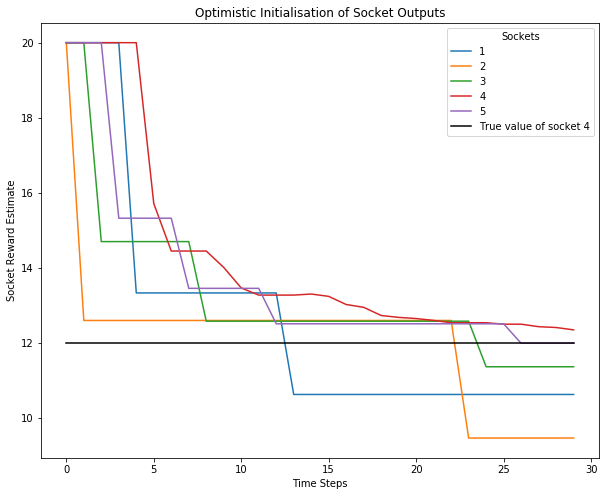

In [6]:
plt.figure(figsize=(10,8))

for socket in range(estimates.shape[1]):
    plt.plot(estimates[:30,socket], label = f'{socket+1}')       

plt.plot(np.ones(30)*np.max(socket_means),'k', label = f'True value of socket 4')

plt.legend(title = 'Sockets')
plt.title('Optimistic Initialisation of Socket Outputs')
plt.xlabel('Time Steps')
plt.ylabel('Socket Reward Estimate')

From the graph above it can be seen that the Optimistic Greedy algorithm works pretty well. It doesn't take too long for the sub-optimal actions to be discarded and for the focus to turn to the optimal action, which is the action we want to take if we're to get the maximum amount of charge in the shortest amount of time.

However, there are a couple of problems with our experiment:

* Firstly, we cheated! We chose the initial socket estimate of 20 based on our knowledge of the socket outputs. In the real world, and in Baby Robot's case, we probably don't have this knowledge.

* Secondly, we weren't very good at cheating! We chose the value of 20 because it was slightly higher than the highest output we obtained when looking at the socket outputs (see socket 4's output in the violin-plot above). However, it turns out that this isn't the best value.

Take a look at the plots below, showing the mean total reward and the socket selection percentages, obtained over 30 time steps for a range of initial values.

In [7]:
def plot_initial_optimisation( initial_values, reward, max_initial_value, figsize=(10,8) ):

    plt.figure(figsize=figsize)
    plt.plot( initial_values, reward, marker='o', linestyle='--', color='r') 

    # draw reference lines
    plt.plot(np.ones(max_initial_value+1)*np.max(socket_means),'k', label = f'Maximum Socket Reward')
    plt.plot(np.ones(max_initial_value+1)*np.mean(socket_means),'b', label = f'Mean Socket Reward')

    plt.legend(title = 'Key:')
    plt.title('Optimistic Initialisation: Mean Total Reward vs Initial Values')
    plt.xlabel('Initial Values')
    plt.ylabel('Mean Total Reward')

In [8]:
def run_initialisation_experiment( start, end, step = 1 ):    
    """ test varying the initial estimate for optimistic-greedy """
            
    number_of_tests = 1000
    number_of_steps = 30
    number_of_sockets = len(socket_order)    
    
    reward = []
    optimal_selected = []
    socket_percentages = []
    initial_values = []
        
    # iterate over the initial estimate values
    for initial_estimate in tqdm(range( start, (end+step), step )):
        
        initial_values.append( initial_estimate )

        socket_tester = SocketTester( OptimisticSocket, socket_order, initial_estimate = initial_estimate)

        socket_experiment = SocketExperiment(socket_tester = socket_tester,
                                             number_of_tests = number_of_tests,
                                             number_of_steps = number_of_steps)
        socket_experiment.run()
        
        reward.append( socket_experiment.get_mean_total_reward() )
        optimal_selected.append( socket_experiment.get_optimal_selected() )
        socket_percentages.append( socket_experiment.get_socket_percentages() )                
     
    return initial_values, reward, optimal_selected, socket_percentages         

100%|██████████| 11/11 [00:14<00:00,  1.34s/it]


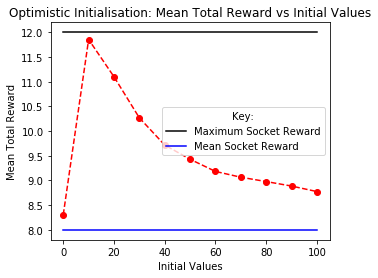

In [9]:
max_initial_value = 100   
step = 10
initial_values, reward, optimal_selected, socket_percentages = run_initialisation_experiment( 0, max_initial_value, step )    
plot_initial_optimisation( initial_values, reward, max_initial_value, figsize=(5,4) )

Text(0, 0.5, 'Socket Selection (%)')

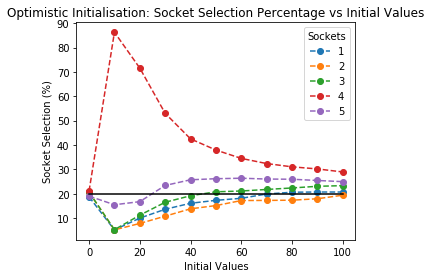

In [10]:
df = pd.DataFrame(socket_percentages)

plt.figure(figsize=(5,4))

for socket in range(df.shape[1]):
    plt.plot(initial_values, df[socket]*100, label = f'{socket+1}', marker='o', linestyle='--')           

plt.plot(initial_values, np.ones(df.shape[0])*20,'k')

plt.legend(title = 'Sockets')
plt.title('Optimistic Initialisation: Socket Selection Percentage vs Initial Values')
plt.xlabel('Initial Values')
plt.ylabel('Socket Selection (%)')

In the plots above, there are a few points of note:

* When the initial socket values are set to zero the mean total reward has a value of approximately 8. In this case the pure Greedy Algorithm is being implemented. There is no exploration, only exploitation, so sockets will be chosen randomly. In our case the mean socket outputs are 4, 6, 8, 10 and 12, so the mean socket reward is 8. This can also be seen in the graph of socket selection percentages. With an initialisation value of zero, all sockets are chosen with equal probability and, since there are 5 sockets, each is chosen with a 20% probability.

* Similarly, with very large initial values, the mean total reward starts to decrease to towards a value of 8, marking the point at which all sockets have been selected with an equal probability. In this case the reward returned from each socket is much smaller than the chosen initial value. It therefore takes much longer for the estimated reward to fall to a value close to the true maximum reward. During this time each socket will have approximately equal over-estimations of the true reward.

* The maximum mean total reward doesn't occur with an initialisation value of 20. Instead, as shown in Figure 3.3 below, it actually occurs when the initial estimates are set to 11. This can also be seen in the graph of selection probability above in which, for an initial value of 11, the probability of selecting the optimal socket increases to a maximum value, while at the same time decreasing to a minimum for all other sockets. Since this initialisation value is greater than all but the optimal socket reward, as soon as the optimal socket is selected its estimated reward will be set higher than all others (assuming it returns close to its mean reward value) and so it will then be greedily chosen for all the remaining time steps. So the optimal socket only needs to be tested once to make it the greedy action.

100%|██████████| 21/21 [00:29<00:00,  1.38s/it]


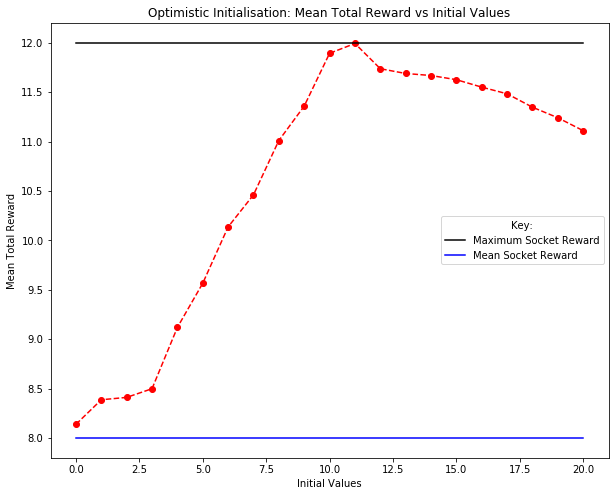

In [11]:
max_initial_value = 20   
step = 1
initial_values, reward, optimal_selected, socket_percentages = run_initialisation_experiment( 0, max_initial_value, step )    
plot_initial_optimisation( initial_values, reward, max_initial_value )

---

The Optimistic-Greedy algorithm is a simple way to encourage exploration during the early stages of testing. Initially all actions will be tried and, if a suitable initialisation value is used, the algorithm will quickly discard non-optimal actions and focus on the best actions. However, as shown above, a poorly chosen initial value can result in sub-optimal total return and, without some prior knowledge of the range of possible rewards, it can be hard to select the best initial values.

Another major drawback is the fact that exploration is confined to the initial time steps, restricting its use to stationary problems, in which the rewards for each action never change. It is not suitable for non-stationary situations, where the action rewards can change with time, due to the lack of ongoing exploration.


---

# The Epsilon-Greedy Algorithm (ε-Greedy)

As we've seen, a pure Greedy strategy has a very high risk of selecting a sub-optimal socket and then sticking with this selection. As a result, the best socket will never be found.

A simple way to overcome this problem is by introducing an element of exploration. This is exactly what Epsilon-Greedy does:

* By default, actions are chosen greedily. The action with the highest estimated reward is the selected action.

* However, at each time step, an action may instead be selected at random from the set of all possible actions. A random action is chosen with a probability 'ε' (Epsilon).

In this way exploration is added to the standard Greedy algorithm. Over time every action will be sampled repeatedly to give an increasingly accurate estimate of its true reward value.

The code to implement the Epsilon-Greedy strategy is shown below. Note that this changes the behaviour of the socket tester class, modifying how it chooses between the available sockets, rather than a change to the actual sockets.

At each time step '<i>select_socket</i>' is called. If the random value '<i>p</i>' is less than Epsilon then a random action will be chosen, otherwise the socket with the highest current estimated reward will be selected.

In [12]:
class EpsilonGreedySocketTester( SocketTester ):

    def __init__(self, epsilon = 0. ):  
        
        # create a standard socket tester
        super().__init__() 
        
        # save the probability of selecting the non-greedy action
        self.epsilon = epsilon
    
    
    def select_socket( self, t ):
        """ Epsilon-Greedy Socket Selection"""
        
        # probability of selecting a random socket
        p = np.random.random()

        # if the probability is less than epsilon then a random socket is chosen from the complete set
        if p < self.epsilon:
            socket_index = np.random.choice(self.number_of_sockets)
        else:
            # choose the socket with the current highest mean reward or arbitrary select a socket in the case of a tie            
            socket_index = random_argmax([socket.sample(t) for socket in self.sockets])               
        
        return socket_index

Looking at the graphs below, it can be seen how the value of ε affects exploration and exploitation on the socket problem:

In [13]:
# create and test epsilon-greedy sockets
tester = EpsilonGreedySocketTester( epsilon = 0.1 )
tester.run( number_of_steps = 1000 )

print(f'Mean Reward per Time Step = {tester.get_mean_reward()}')
print(f'Optimal Socket Selected = {tester.get_optimal_socket_percentage()}')
print(f'Socket Percentages = {tester.get_socket_percentages()}')

Mean Reward per Time Step = 11.558513275289732
Optimal Socket Selected = 0.918918918918919
Socket Percentages = [0.021 0.024 0.013 0.919 0.023]


In [14]:
def plot_epsilon_greedy_socket_percentages( epsilon_values, socket_percentages, number_of_steps ):

    df = pd.DataFrame(socket_percentages)
    for socket in range(df.shape[1]):
        plt.plot(epsilon_values, df[socket]*100, label = f'{socket+1}', marker='o', linestyle='--')           

    plt.plot(epsilon_values, np.ones(df.shape[0])*20,'k')

    plt.legend(title = 'Sockets')
    plt.title('Socket Selection Percentage vs Epsilon', fontsize=15)
    plt.xlabel('Epsilon')
    plt.ylabel('Socket Selection (%)')
     
def plot_epsilon_greedy_final_socket_estimates( epsilon_values, final_socket_estimates, number_of_steps ):    
    df = pd.DataFrame(final_socket_estimates)
    for socket in range(df.shape[1]):
        plt.plot(epsilon_values, df[socket], label = f'{socket+1}', marker='o', linestyle='--')           

    plt.legend(title = 'Sockets')
    plt.title('Final Socket Estimate vs Epsilon', fontsize=15)
    plt.xlabel('Epsilon')
    plt.ylabel('Final Socket Estimate')    
    
def plot_epsilon_greedy_reward_per_timestep( epsilon_values, reward_per_timestep, number_of_steps, figsize=(10,8) ):
    
    plt.plot( epsilon_values, reward_per_timestep, marker='o', linestyle='--', color='r') 
    plt.title('Mean Total Reward per Time Step vs Epsilon', fontsize=15)
    plt.xlabel('Epsilon')
    plt.ylabel('Mean Total Reward per Time Step')  
    
    
def plot_epsilon_greedy(epsilon_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates, number_of_steps ):
    fig = plt.figure(figsize=(26,5))

    plt.suptitle(f'Epsilon Greedy: {number_of_steps} time-steps per run', fontsize=20, fontweight='bold')

    plt.subplot(1, 3, 1)
    plot_epsilon_greedy_socket_percentages( epsilon_values, socket_percentages, number_of_steps )

    plt.subplot(1, 3, 2)
    plot_epsilon_greedy_reward_per_timestep( epsilon_values, reward_per_timestep, number_of_steps )

    plt.subplot(1, 3, 3)
    plot_epsilon_greedy_final_socket_estimates( epsilon_values, final_socket_estimates, number_of_steps )

    plt.show()   

In [15]:
def epsilon_greedy_experiment( number_of_tests, number_of_steps, epsilon = 0.):    
    
    experiment = SocketExperiment(socket_tester   = EpsilonGreedySocketTester( epsilon ),
                                  number_of_tests = number_of_tests,
                                  number_of_steps = number_of_steps)
    experiment.run()
    
    return experiment.get_estimates(),\
           experiment.get_mean_total_reward(),\
           experiment.get_optimal_selected(),\
           experiment.get_socket_percentages()

In [16]:
def run_epsilon_greedy_experiment( start, end, step = 0.01, number_of_tests = 100, number_of_steps = 300 ):     

    test_values = []
    reward_per_timestep = []
    optimal_selected = []
    socket_percentages = []
    final_socket_estimates = []
        
    # iterate over the epsilon values
    for epsilon in tqdm( np.arange( start, (end+step), step ) ):
        
        # save the test value used to run this test
        test_values.append( epsilon )
        
        mean_estimates, mean_reward_per_timestep, mean_optimal_selected, mean_socket_percentage = epsilon_greedy_experiment( number_of_tests, number_of_steps, epsilon )                           
                
        reward_per_timestep.append( mean_reward_per_timestep )
        optimal_selected.append( mean_optimal_selected )
        socket_percentages.append( mean_socket_percentage ) 
        final_socket_estimates.append( mean_estimates[-1] )
     
    return test_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates                    

100%|██████████| 21/21 [00:43<00:00,  2.08s/it]


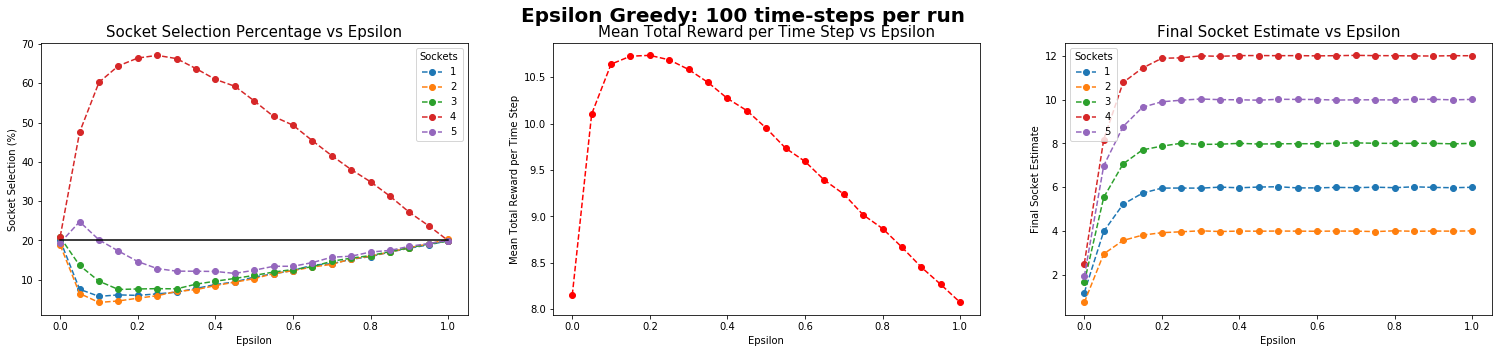

In [17]:
# how many times each test should be run
number_of_tests = 500

# the epsilon test range
start = 0
stop = 1.0
step = 0.05

number_of_steps = 100
epsilon_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates = \
    run_epsilon_greedy_experiment( start, stop, step, number_of_tests, number_of_steps )  

plot_epsilon_greedy(epsilon_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates, number_of_steps )

* With an ε value of zero this is just the Greedy algorithm. Each socket is chosen with an equal probability. No sockets are ever selected at random and there is no exploration.

* As ε increases, so the random selection of actions increases and, consequently, exploration increases. Initially this results in the optimal socket being located and selected with increasing frequency. At the same time, the non-optimal sockets begin to be selected less often.

* The selection of the optimal socket, and the corresponding rise in the mean total reward, continues up to an ε value of approximately 0.2. This point represents the peak in the exploration\exploitation trade-off. Exploration is finding the best action to take and exploitation is selecting this action.

* After the peak in the selection of the optimal socket the balance between exploration and exploitation starts to shift in favour of exploration. The chances of a socket being chosen at random becomes increasingly likely. As a result, non-optimal sockets begin to be chosen more frequently and so the mean total reward begins to fall.

* The increase in the random selection of sockets continues until ε has a value of 1, at which point the algorithm has switched to become a pure exploration strategy with no exploitation. Sockets are once again chosen purely at random and each socket is chosen with equal probability, irrespective of its estimated reward.



The Epsilon-Greedy strategy is an easy way to add exploration to the basic Greedy algorithm. Due to the random sampling of actions, the estimated reward values of all actions will converge on their true values. This can be seen in the graph of Final Socket Estimates shown above. With ε values higher than about 0.2, the estimated socket values all match their true values. And this is also the downside of the Epsilon-Greedy algorithm: non-optimal actions continue to be chosen, and their reward estimates refined, long after they have been identified as being non-optimal. Consequently, exploitation of the optimal action isn't maximised and the total overall reward is less than it could be.

---

# Regret

In the socket selection problem the maximum possible reward would be obtained if the best socket was chosen at every time step. Every time a non-optimal socket is selected the total possible reward that can be obtained reduces further from this theoretical maximum. As a result you regret choosing this socket and wish instead that you'd chosen the best one. As the term regret implies, you may have no way to know in advance that you're making a non-optimal choice, only in hindsight do you realise your mistake.

Although it may not be possible to tell in advance if you're choosing the best action, you can calculate how your selection policy performs when compared against the optimal policy, in which the best action is selected at every time step. The difference in the total reward obtained by these two policies represents the regret.

The optimal action is given by:


![](Images/optimal_action_formula.png)


<i>The optimal action is the one which maximises the expected (mean) reward when it is chosen at every time step.</i>

The regret 'L' is calculated by taking the difference between the reward obtained by the implemented policy and the reward that would have been obtained if instead the optimal policy had been followed, over a total of 'T' time steps:

![](Images/regret_formula.png)


So, for all 'T' time steps, the optimal policy gets the expected reward obtained when taking the optimal action at every time step. From this we subtract the sum of the expected rewards returned from the actions chosen by our policy, where the chosen action, and therefore its expected reward, can vary at every time step.

By minimising the value of the regret we can maximise the sum of the rewards.


---

## Epsilon-Greedy Regret
Epsilon-Greedy implements exploration by choosing any of the possible actions, at random, with a probability 'ε'. Therefore, over the course of 'T' time steps, 'εT' of the actions will have been chosen randomly.

Additionally, in a general form of the socket selection problem, there are 'k' different sockets to choose from and only one of these will give the maximum possible reward. The remaining 'k-1' sockets will give a sub-optimal reward. As a result, there are 'εT(k-1)/k' rounds in which a sub-optimal socket is selected.

If, during the rounds when the sub-optimal action is chosen, we get lucky and instead choose the second best socket, where the reward differs by a fixed amount 'Δ' (delta) from the best socket, then this will give us the lowest possible regret for Epsilon-Greedy. This is given by:


![](Images/epsilon_greedy_regret.png)


For all other non-optimal sockets the difference between the obtained reward and the optimal reward will be higher than 'Δ', hence the greater than or equal sign, since in this case the regret will be larger.

Since 'ε', 'Δ' and 'k' are all constants, the resultant lowest bounds regret for Epsilon-Greedy is linear with time ('T' will just be multiplied by a constant value). Meaning that the regret will continue to increase long after the optimal action has been found.

This can be seen in the graphs of Epsilon Greedy Regret shown below. After the first few time steps the total accumulated reward obtained by the Epsilon Greedy method increases linearly. However, due to the random exploration that still occurs, this rate of increase is slightly less than the rate at which the optimal action would accumulate its reward, resulting in the linear increase in the regret over time. The slightly higher rate of increase in regret that occurs during the early stages of the run is due to the best action not yet having been located and so a sub-optimal socket is more likely to be selected during these time steps.

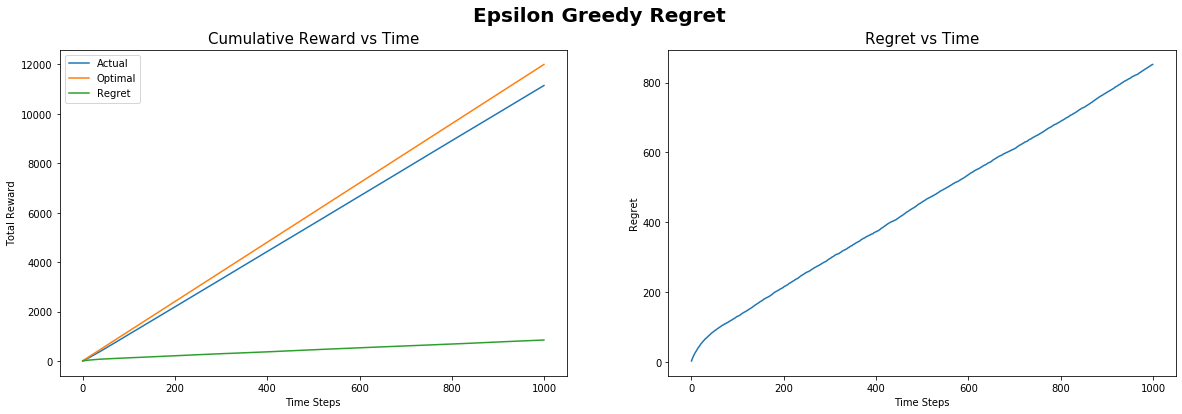

In [18]:
# run the test 100 times with each test running for 1000 timesteps
number_of_tests = 100
number_of_steps = 1000    
epsilon = 0.2

experiment = SocketExperiment(socket_tester   = EpsilonGreedySocketTester( epsilon ),
                              number_of_tests = number_of_tests,
                              number_of_steps = number_of_steps)
experiment.run()


# best socket has a true mean reward of 12
cummulative_optimal_reward = [r*12 for r in range(1,number_of_steps+1)]

# regret is the difference between the optimal reward and the actual reward 
regret = cummulative_optimal_reward - experiment.get_cumulative_reward_per_timestep()


fig = plt.figure(figsize=(20,6))
plt.suptitle(f'Epsilon Greedy Regret', fontsize=20, fontweight='bold')

plt.subplot(1, 2, 1)
plt.plot(experiment.get_cumulative_reward_per_timestep(),label = "Actual")
plt.plot(cummulative_optimal_reward, label ="Optimal")
plt.plot(regret, label ="Regret")
plt.legend()
plt.title('Cumulative Reward vs Time', fontsize=15)
plt.xlabel('Time Steps')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.title('Regret vs Time', fontsize=15)
plt.plot(regret)
plt.xlabel('Time Steps')
plt.ylabel('Regret')

plt.show()  

---

# Summary

In this part of our look at Multi-Armed Bandits we finally got to investigate some of the algorithms that can be used to tackle the bandit problem. 

The pure Greedy algorithm, unless it has some initial knowledge of the possible action rewards, doesn't fare much better than a simple random selection method. However, with some slight modifications, such as Optimistic-Greedy's use of large initial values or Epsilon Greedy's approach of introducing random exploration, the selection performance can be greatly improved.

However, even with these improvements, the total reward that is returned is still much less than optimal. Optimistic-Greedy's performance is very dependent on the values selected for its initial rewards and Epsilon Greedy continues to explore the set of all actions, long after it has gained sufficient knowledge to know which of these actions are bad actions to take. As a result, the Epsilon Greedy algorithm was shown to have linear regret, where the difference between the returned reward and the optimal reward continued to increase linearly with time. 

In the remaining parts of this series we'll take a look at a couple of more sophisticated approaches to solving the Bandit Problem, namely the Upper Confidence Bound algorithm and Thompson Sampling, both of which reduce the level of regret, resulting in a higher level of return. Using these we'll get Baby Robot charged in super quick time!


![](Images/green_babyrobot_small.gif)